<a href="https://colab.research.google.com/github/pablopuch/DengAI/blob/main/dengue.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DengAI: Predicting Disease Spread

* submission_format.csv = ejemplo de fichero a subir
* labels_train.csv = resultado (Y)
* features_train.csv = caracteristicas (X)
* features_test.csv = para hacer el predict con el modelo entrenado

# Importamos las librerias y la concecíon con Google Drive.
En este apartado realizamos las importaciones de todas las librerías que vamos a utilizar y realizamos la conexión con el google drive que es donde tenemos los datos guardados.

In [ ]:
import pandas as pd
import io
from google.colab import files
from google.colab import drive
import matplotlib.pyplot as plt
import numpy as np
import itertools
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn import neighbors
from sklearn.metrics import mean_absolute_error

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Importamos los csv que nos dan la competición.

In [ ]:
test_feat = pd.read_csv("/content/drive/MyDrive/dengue/dengue_features_test.csv")
train_feat = pd.read_csv("/content/drive/MyDrive/dengue/dengue_features_train.csv")
labels_train = pd.read_csv("/content/drive/MyDrive/dengue/dengue_labels_train.csv")
train_feat

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1451,iq,2010,21,2010-05-28,0.342750,0.318900,0.256343,0.292514,55.30,299.334286,...,45.00,88.765714,55.30,18.485714,9.800000,28.633333,11.933333,35.4,22.4,27.0
1452,iq,2010,22,2010-06-04,0.160157,0.160371,0.136043,0.225657,86.47,298.330000,...,207.10,91.600000,86.47,18.070000,7.471429,27.433333,10.500000,34.7,21.7,36.6
1453,iq,2010,23,2010-06-11,0.247057,0.146057,0.250357,0.233714,58.94,296.598571,...,50.60,94.280000,58.94,17.008571,7.500000,24.400000,6.900000,32.2,19.2,7.4
1454,iq,2010,24,2010-06-18,0.333914,0.245771,0.278886,0.325486,59.67,296.345714,...,62.33,94.660000,59.67,16.815714,7.871429,25.433333,8.733333,31.2,21.0,16.0


**Ahora vamos a mostrar los datos que contienen los CSV y ver que nose encontramos.**

In [ ]:
train_feat.columns

Index(['city', 'year', 'weekofyear', 'week_start_date', 'ndvi_ne', 'ndvi_nw',
       'ndvi_se', 'ndvi_sw', 'precipitation_amt_mm', 'reanalysis_air_temp_k',
       'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k',
       'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k',
       'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
       'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
       'station_min_temp_c', 'station_precip_mm'],
      dtype='object')

In [ ]:
labels_train

,city,year,weekofyear,total_cases
0,sj,1990,18,4
1,sj,1990,19,5
2,sj,1990,20,4
3,sj,1990,21,3
4,sj,1990,22,6
...,...,...,...,...
1451,iq,2010,21,5
1452,iq,2010,22,8
1453,iq,2010,23,1
1454,iq,2010,24,1


**Tabla de Correlacíon**

<Axes: >

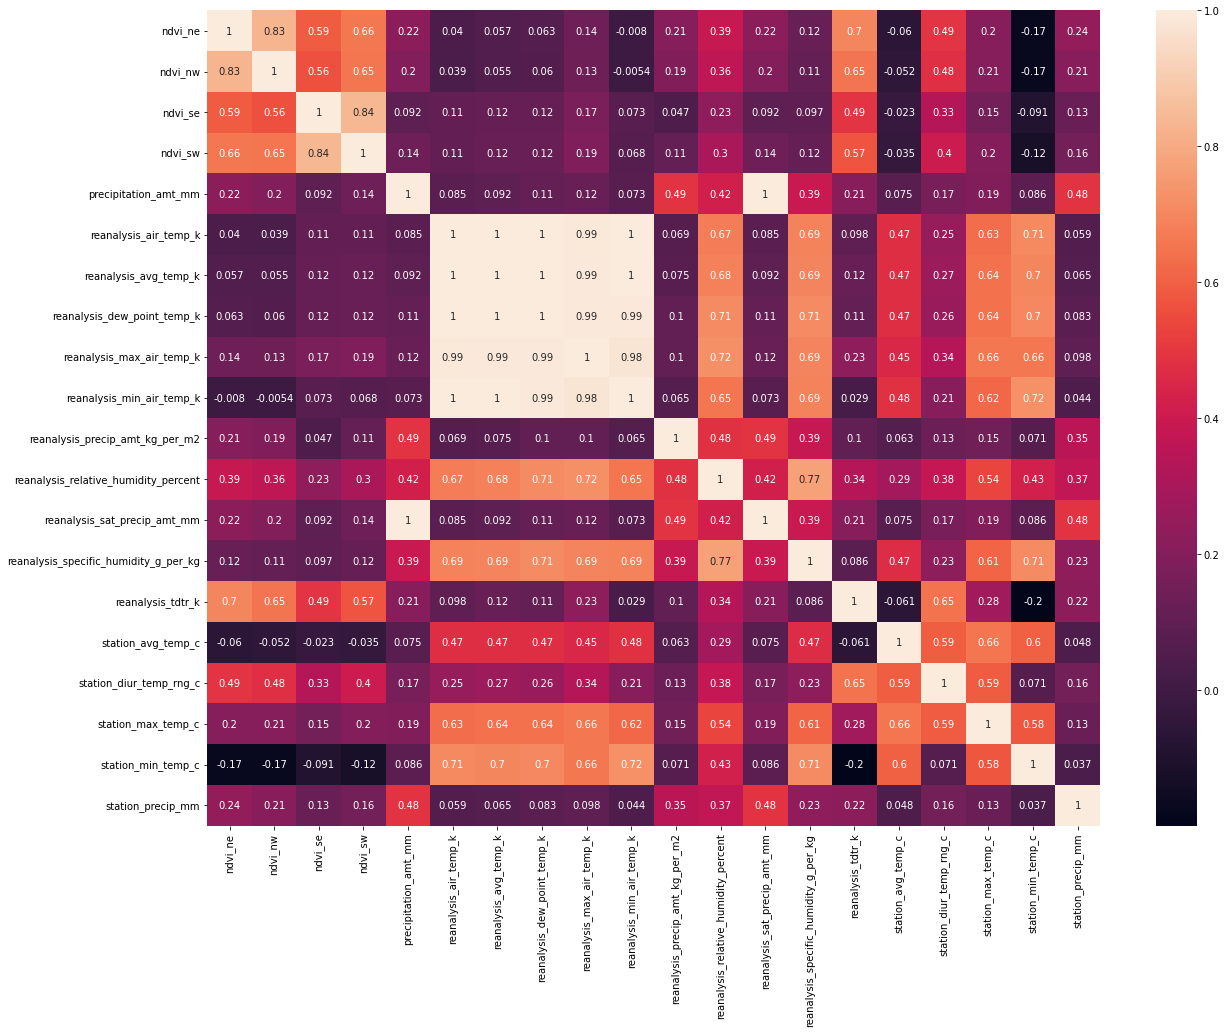

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 15))
sns.heatmap(train_feat.corr(), annot=True)

<ipython-input-6-a471c7f074a8>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(labels_train.total_cases)


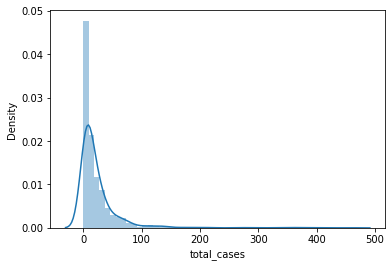

In [ ]:
sns.distplot(labels_train.total_cases)
plt.show()

# Moldeando los Datos
En este bloque de código lo que hacemos es eliminar las columnas que no creemos que son relevantes para la predicción

In [ ]:
train_feat = train_feat.drop(['week_start_date', 'city','year','weekofyear'], axis=1)
test_feat = test_feat.drop(['week_start_date','city','year','weekofyear'], axis=1)

train_feat = train_feat.fillna(0)
test_feat = test_feat.fillna(0)

# Modelos
Para esta conpeticíon vamos a realizar varios modelos distintos.


1.   KNN
2.   Arbol de dección con RandomForestRegressor
3.   Árbol de dicción con AdaBoostRegressor y haciendo una Hiperparametrisación de los datos con GridSearchCV.
4.   Árbol de decisión con GradientBoostingRegressor y haciendo una Hiperparametrisación de los datos con RandomizedSearchCV.



# 1º Modelo de KNN

Sepraramos los datos de entrenaiemnto "train" y los de testeo "test".

In [ ]:
from sklearn.model_selection import train_test_split

# feature selection and transformation
X_Train = train_feat
Y_Train = labels_train['total_cases']

# train and test
X_train, X_test, Y_train, Y_test = train_test_split(X_Train, Y_Train, test_size=0.3)

**Entrenamos el modelo**

Min Value uniform : 21.258581235697935 (29)
Min Value distance : 21.043373568077417 (29)


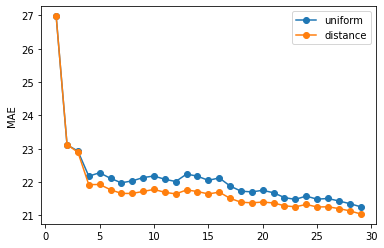

In [ ]:
cv = TimeSeriesSplit(n_splits = 10)
X_Train.reset_index(drop=True,inplace=True) 

for i, weights in enumerate(['uniform', 'distance']):
   total_scores = []
   for n_neighbors in range(1,30):
       fold_accuracy = []
       knn = neighbors.KNeighborsRegressor(n_neighbors, weights=weights)
       # verificar cada uno de los modelos con validación cruzada.
       for train_fold, test_fold in cv.split(X_Train):
          # División train test aleatoria
          f_train = X_Train.loc[train_fold]
          f_test = X_Train.loc[test_fold]
          # entrenamiento y ejecución del modelo
          knn.fit(X_train, Y_train)
          Y_Pred = knn.predict(X_test)
          # evaluación del modelo
          mae = mean_absolute_error(Y_test,Y_Pred)
          fold_accuracy.append(mae)
       total_scores.append(sum(fold_accuracy)/len(fold_accuracy))
   
   plt.plot(range(1,len(total_scores)+1), total_scores, marker='o', label=weights)
   print ('Min Value ' +  weights + " : " +  str(min(total_scores)) +" (" + str(np.argmin(total_scores) + 1) + ")")
   plt.ylabel('MAE')      
    
plt.legend()
plt.show()

In [ ]:
n_neighbors = np.argmin(total_scores) + 1
print(np.argmin(total_scores)+ 1)

29


**Realizamos la Predicción**

In [ ]:
# constructor
weights = 'distance'
knn = neighbors.KNeighborsRegressor(n_neighbors= n_neighbors, weights=weights)

# fit and predict
knn.fit(X_Train, Y_Train)
Y_Pred = knn.predict(test_feat)

**Por ultimo Descargamos un fichero que subiéremos a la competición.**

In [ ]:
var = pd.read_csv('/content/drive/MyDrive/dengue/submission_format.csv')
var['total_cases'] = Y_Pred.astype(int)

var.to_csv('Dengue_Results.csv', index=False)
files.download('Dengue_Results.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# 2º Arbol de dección con RandomForestRegressor



In [ ]:
from sklearn.model_selection import train_test_split

# feature selection and transformation
X_Train = train_feat
Y_Train = labels_train['total_cases']

# train and test
X_train, X_test, Y_train, Y_test = train_test_split(X_Train, Y_Train, test_size=0.3)

En este apartado realiza validación cruzada en un modelo Regresor de Bosques Aleatorios con diferentes números de estimadores (árboles de decisión).




In [ ]:
l_estimators = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]

cv = TimeSeriesSplit(n_splits = 10)
X_Train.reset_index(drop=True,inplace=True)

total_scores = []
for estimators in l_estimators:
    fold_accuracy = []
    regressor = RandomForestRegressor(n_estimators= estimators, criterion='absolute_error', random_state=0)
    # verificar cada uno de los modelos con validación cruzada.
    for train_fold, test_fold in cv.split(X_Train):
      # División train test aleatoria
      f_train = X_Train.loc[train_fold]
      f_test = X_Train.loc[test_fold]
      # entrenamiento y ejecución del modelo
      regressor.fit(X_train, Y_train)
      Y_Pred = regressor.predict(X_test)
      # evaluación del modelo
      mae = mean_absolute_error(Y_test,Y_Pred)
      fold_accuracy.append(mae)
    total_scores.append(sum(fold_accuracy)/len(fold_accuracy))
   
plt.plot(l_estimators, total_scores, marker='o')
print ('Min Value :' +  str(min(total_scores)) +" (" + str(np.argmin(total_scores) + 1) + ")")
plt.ylabel('MAE')      
    
plt.legend()
plt.show()

In [ ]:
best_est = l_estimators[np.argmin(total_scores)]
best_mae = min(total_scores)
print ("Min Value (estimators = %i, MAE = %6.2f)"  % (best_est, best_mae))

**Entrenamiento del modelo y predicación**

In [ ]:
# constructor
regressor =  RandomForestRegressor(n_estimators= best_est, criterion='absolute_error', random_state=0)
# fit and predict


for train_fold, test_fold in cv.split(X_Train):
  # División train test aleatoria
  f_train = X_Train.loc[train_fold]
  f_test = X_Train.loc[test_fold]
  # entrenamiento y ejecución del modelo
  regressor.fit(X_train,Y_train)

# MUY INTERESANTE: Entrenar sin CV y observar la diferencia del MAE, realizando el train SIN cv y CON cv
#regressor.fit( X = train.drop(['count'], axis=1), y = train['count'])
Y_Pred = regressor.predict(test_feat)

**Descargamos los datos para subirlos a la competición**

In [ ]:
var = pd.read_csv('/content/drive/MyDrive/dengue/submission_format.csv')
var['total_cases'] = Y_Pred.astype(int)

var.to_csv('Dengue_Results.csv', index=False)
files.download('Dengue_Results.csv')

Historico de Resultados

1. --27.2933
2. --27.6875
3. --27.3269
4. --27.0841




# 3º Árbol de dicción con AdaBoostRegressor con GridSearchCV.

In [ ]:
from sklearn.model_selection import train_test_split

# feature selection and transformation
X_Train = train_feat
Y_Train = labels_train['total_cases']

# train and test
X_train, X_test, Y_train, Y_test = train_test_split(X_Train, Y_Train, test_size=0.3)

**Entrenamiento del modelo y predicación**

In [ ]:
param_dist = {
  "n_estimators": [8, 32, 64, 128],
  "learning_rate" : [0.01,0.05,0.1],
  "loss" : ['linear', 'square', 'exponential']
 }

cv = TimeSeriesSplit(n_splits = 10)

grid_ada = GridSearchCV(
    estimator=AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=6, criterion='absolute_error')), 
    param_grid=param_dist, 
    cv=10)

grid_ada.fit(X_train,Y_train)

best_ada = grid_ada.best_estimator_
print (best_ada)

# fit and predict
best_ada.fit(X_train, Y_train)
Y_Pred = best_ada.predict(test_feat)

In [ ]:
# # Definir la tubería de preprocesamiento y modelado
# pipeline = Pipeline([
#     ('scaler', StandardScaler()),
#     ('regressor', AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=6, criterion='absolute_error')))
# ])

# # Definir el diccionario de parámetros con más opciones
# param_dist = {
#     "regressor__n_estimators": [8, 16, 32, 64, 128],
#     "regressor__learning_rate" : [0.001, 0.01, 0.1, 1],
#     "regressor__loss" : ['linear', 'square', 'exponential'],
#     "regressor__base_estimator__max_features": ['auto', 'sqrt', 'log2'],
#     "regressor__base_estimator__min_samples_leaf": [1, 2, 4]
# }

# # Definir el objeto de validación cruzada
# loo = LeaveOneOut()

# # Definir el objeto de búsqueda de cuadrícula con una validación cruzada más rigurosa
# grid_ada = GridSearchCV(
#     estimator=pipeline, 
#     param_grid=param_dist, 
#     cv=loo,
#     scoring='neg_mean_squared_error',
#     n_jobs=-1)

# # Ajustar el modelo
# grid_ada.fit(X_train, Y_train)

# # Obtener el mejor modelo y predecir los resultados
# best_ada = grid_ada.best_estimator_
# Y_Pred = best_ada.predict(test_feat)

# # Imprimir los resultados
# print('Mejor modelo: ', best_ada)
# print('Resultado de la predicción: ', Y_Pred)

**Descargamos los datos para subirlos a la competición**

In [ ]:
var = pd.read_csv('/content/drive/MyDrive/dengue/submission_format.csv')
var['total_cases'] = Y_Pred.astype(int)

var.to_csv('Dengue_Results.csv', index=False)
files.download('Dengue_Results.csv')

Historico de resultados
1.  26.6514
2.  27.1587
3.  27.2933

# 4º Arbol de dección de GradientBoostingRegressor con RandomForestRegressor

In [ ]:
from sklearn.model_selection import train_test_split

# feature selection and transformation
X_Train = train_feat
Y_Train = labels_train['total_cases']

# train and test
X_train, X_test, Y_train, Y_test = train_test_split(X_Train, Y_Train, test_size=0.3)

In [ ]:
from scipy.stats import randint as sp_randint
random_test=sp_randint(2, 50)
cv = TimeSeriesSplit(n_splits = 10)

**Entrenamiento del modelo y predicación**

In [ ]:
param_dist = {"n_estimators": [4, 8, 16, 32, 64, 128],
              "learning_rate": [0.1, 0.25, 0.5, 0.75, 1],
              "max_depth": [2, 3, 4, 5, 6, None],
              "min_samples_split": [2, 5, 10, 15, 20, 25],
              "min_samples_leaf": [1, 2, 4, 8, 16, 32],
              "max_features": ['auto', 'sqrt', 'log2', None]}

rnd_regres = RandomizedSearchCV(
    estimator=GradientBoostingRegressor(random_state=0, loss='squared_error'),
    param_distributions=param_dist,
    n_iter=100,
    cv=10,
    random_state=0,
    n_jobs=100
)

rnd_regres.fit(X_train,Y_train)
best_gbr = rnd_regres.best_estimator_
print (best_gbr)

# fit and predict
best_gbr.fit(X_train, Y_train)
Y_Pred = best_gbr.predict(test_feat)

**Descargamos los datos para subirlos a la competición**

In [ ]:
var = pd.read_csv('/content/drive/MyDrive/dengue/submission_format.csv')
var['total_cases'] = Y_Pred.astype(int)

var.to_csv('Dengue_Results.csv', index=False)
files.download('Dengue_Results.csv')

Historico de resultados
1.   --27.0553
2.   --27.8125
3.   --27.7909
4.   --27.3269